# Predicción de Accidentes Cerebrovasculares Utilizando Técnicas de Aprendizaje Automático

## Análisis Exploratorio de Datos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

df = pd.read_csv("healthcare-dataset-stroke-data.csv")

numeric_columns = ['age', 'avg_glucose_level', 'bmi']
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [18]:
# Describir el DataFrame
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [17]:
# Mostrar información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [15]:
# Mostrar la cantidad de nulos
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
# Seleccionamos columnas numéricas
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[num_cols].hist(figsize=(10, 10), bins=30)
plt.tight_layout()
plt.show()

# # Diagramas de caja
# for col in num_cols:
#     plt.figure(figsize=(6, 4))
#     plt.title(f'Diagrama de caja para {col}')
#     plt.show()

## Preprocesamiento de Datos e Ingeniería de Características

In [32]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocesor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

## Desarrollo y Evaluación de Modelos

In [37]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


X = df.drop(["id", "stroke"], axis=1)
y = df["stroke"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Deccision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, random_state=42, class_weight="balanced"
    ),
    "SVM (Support Vector Machine)": SVC(
        kernel="rbf", probability=True, class_weight="balanced"
    ),
}

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocesor), ("classifier", model)])
    scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )
    results[name] = {metric: scores[f"test_{metric}"].mean() for metric in scoring}

results_df = pd.DataFrame(results).T.sort_values("f1", ascending=False)
display(results_df)

,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.737281,0.133458,0.798846,0.228658,0.839479
SVM (Support Vector Machine),0.698142,0.119292,0.813974,0.208032,0.817692
Deccision Tree,0.916829,0.142295,0.140513,0.141009,0.548529
Random Forest,0.947407,0.133333,0.020000,0.034783,0.799587


## Ajuste de Hiperparámetros y Selección de Modelos

In [41]:
from sklearn.model_selection import GridSearchCV


param_grid_rf = {
    "classifier__n_estimators": [40, 50, 55, 65],
    "classifier__max_depth": [9, 10, 11],
    "classifier__min_samples_split": [22, 25, 30, 35],
}

pipe_fr = Pipeline(
    steps=[
        ("preprocessor", preprocesor),
        (
            "classifier",
            RandomForestClassifier(random_state=42, class_weight="balanced"),
        ),
    ]
)

grid_search_rf = GridSearchCV(
    pipe_fr,
    param_grid_rf,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1,
)
grid_search_rf.fit(X_train, y_train)

print("Mejores parámetros:", grid_search_rf.best_params_)
print("Mejor puntuación F1:", grid_search_rf.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros: {'classifier__max_depth': 11, 'classifier__min_samples_split': 35, 'classifier__n_estimators': 50}
Mejor puntuación F1: 0.26013319161656756


In [42]:
from sklearn.metrics import classification_report, roc_auc_score


best_model = grid_search_rf.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("Auc-Roc", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0      0.976     0.877     0.924       972
           1      0.195     0.580     0.291        50

    accuracy                          0.862      1022
   macro avg      0.585     0.728     0.608      1022
weighted avg      0.938     0.862     0.893      1022

Auc-Roc 0.8131172839506172


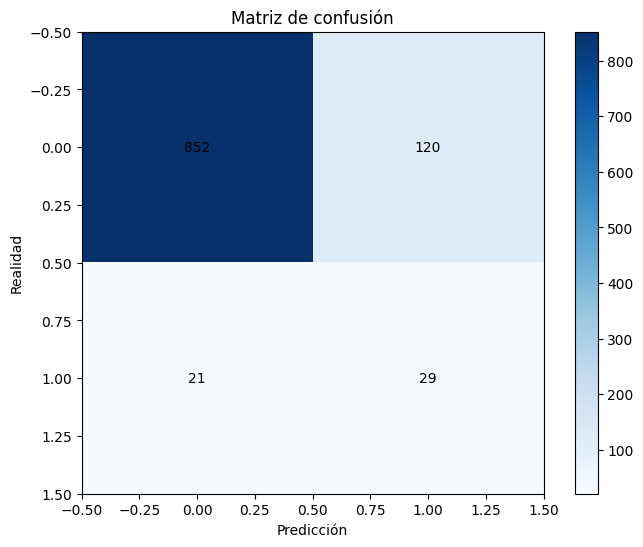

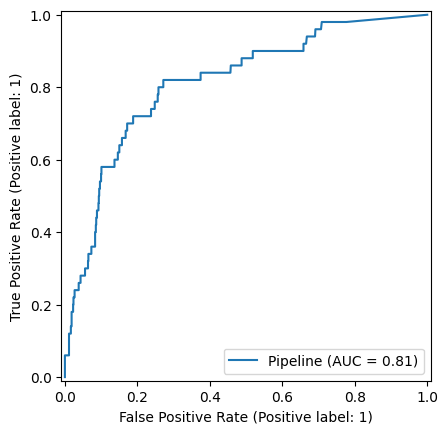

In [43]:
from sklearn.metrics import RocCurveDisplay, confusion_matrix


cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_title("Matriz de confusión")
ax.set_xlabel("Predicción")
ax.set_ylabel("Realidad")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.title("Matriz de confusión")
plt.colorbar(im)
plt.show()

RocCurveDisplay.from_estimator(
    best_model,
    X_test,
    y_test
)
plt.show()

## Técnicas Avanzadas

In [49]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

smote_pipe = ImbPipeline(
    steps=[
        ("preprocessor", preprocesor),
        ("smote", SMOTE(random_state=42)),
        (
            "classifier",
            GradientBoostingClassifier(random_state=42),
        ),
    ]
)

smote_scores = cross_validate(
    smote_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)
pd.DataFrame({metric: smote_scores[f"test_{metric}"].mean() for metric in scoring}, index=["GradientBoosting + SMOTE"])

,accuracy,precision,recall,f1,roc_auc
GradientBoosting + SMOTE,0.783755,0.134735,0.632821,0.222059,0.809096
